## Identifying Downstream Consumers affected by Backdated Corrections on a Locked Reporting Window

LUSID is a [bi-temporal system](https://support.finbourne.com/what-is-bi-temporal-data). This means that any event recorded by LUSID e.g. [Upserting Transactions](https://www.lusid.com/docs/api/#operation/UpsertTransactions) or [Setting Holdings](https://www.lusid.com/docs/api/#operation/SetHoldings) has two dates. An [asAt date](https://support.finbourne.com/what-is-asat-time) and an [effectiveAt date](https://support.finbourne.com/what-is-effectiveat-effectivefrom-time).

To lock off a period for reporting purposes you may produce a bi-temporal cut-off. That is a cut-off datetime in both the effectiveAt and asAt space.

For example you may want to send out a report for the month of January and so you set a cut-off of the 31st of January at 11:59:59pm. This means that any backdated data entered into LUSID after the 31st of January at 11:59:59pm will not be included in the report. Furthermore any data relating to future activity for example pending settlements which occurs after the 31st of January at 11:59:59pm but was entered into the system before the 31st of January at 11:59:59pm will also not be included in the report. *Note in this example the effectiveAt and asAt datetimes are the same. This does not necessarily need to be the case.*

This works great and with LUSID being bi-temporal you can produce such a report without any issues. 

However, what happens if you then discover that a serious error has been made in your report and a large number of transactions are missing? Do you stick with the locked off period? Or do you include the missing transactions to ensure your report is accurate? If you do include the missing transactions:

- How do you know which Portfolios will be affected?
- How do you know which downstream consumers this will affect? 
- How will your downstream consumers know what changes you have made so they can also decide whether or not to re-run their reports?

This notebook steps you through how you can answer all of these questions using LUSID via the following steps:

**1)** Load some transactions to a set of Portfolios and then set a cut-off date for a report which is due to go out. Then after the cut-off date add some additional transactions to the Portfolios some of which occurred before the cut-off date (backdated transactions) and some after (amendment transactions).

**2)** Identify which Portfolios have experienced a backdated transaction which may invalidate the report. 

**3)** Identify which Users consumed data from these Portfolios before the cut-off date and therefore need to be notified that the report may be invalidated.

**4)** For a given affected User and affected Portfolio retrieve the details of all corrections so they can decide on what action to take. 

## 0) Import Libraries

In [1]:
# Import LUSID
import lusid
from lusidjam import RefreshingToken

# Import Libraries
import os
import json
import time as sleep_time
import requests
import pandas as pd
from datetime import datetime, timedelta, time

import pytz
import dateutil.parser
import matplotlib.pyplot as plt
from lusidtools.cocoon.seed_sample_data import seed_data
from lusidtools.cocoon.utilities import create_scope_id
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame

# Authenticate our user and create our API client
api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    app_name="LusidJupyterNotebook")

print ('LUSID Environment Initialised')
print ('LUSID API Version: ', api_factory.build(lusid.api.ApplicationMetadataApi).get_lusid_versions().build_version)

LUSID Environment Initialised
LUSID API Version:  0.5.4408.0


## 1) Load Transactions, Set Cut-Off Date and then Load More Transactions

Unlike the effectiveAt datetime you have no control over the asAt datetime as this is the system time recorded when you interact with LUSID. Therefore, to simulate your example you will load some transactions, set the cut-off to be just after the the transactions have been loaded and then load some additional transactions after the cut-off some of which occurred before the cut-off date (backdated transactions) and some after (amendment transactions).

*Run the cell below to simulate your cut-off and load transactions*

In [2]:
scope = "AuditTrail-" + create_scope_id()
print (f"Loading transactions into scope: {scope}")

# Load a mapping file for loading data
with open(r"data/seed_data.json") as mappings_file:
    seed_data_mapping = json.load(mappings_file)

# Set the effectiveAt time seed for the initial batch of transactions, must be before the current datetime
current_datetime = datetime.now(pytz.UTC)
initial_transactions_effective_at_date = current_datetime - timedelta(days=2)

# The details for all batches of transactions
transactions = [
    {
        "name": "initial_transactions_effective_at_date",
        "effective_at_date": initial_transactions_effective_at_date,
        "file": "data/global_equity_transactions.csv"
    },
    {
        "name": "additional_transactions_backdated_1",
        "effective_at_date": initial_transactions_effective_at_date,
        "file": "data/global_equity_transactions_additional.csv"
    },    
    {
        "name": "additional_transactions_backdated_2",
        "effective_at_date": initial_transactions_effective_at_date + (
            current_datetime - initial_transactions_effective_at_date) / 2,
        "file": "data/global_equity_transactions_additional2.csv"
    },    
    {
        "name": "additional_transactions_backdated_3",
        "effective_at_date": initial_transactions_effective_at_date + (
            current_datetime - initial_transactions_effective_at_date) / 3,
        "file": "data/global_equity_transactions_additional4.csv"
    },  
    {
        "name": "additional_transactions_ammended",
        "effective_at_date": initial_transactions_effective_at_date + (
            current_datetime - initial_transactions_effective_at_date) * 1.5,
        "file": "data/global_equity_transactions_additional3.csv"
    },
]

# Load each batch in, waiting 5 seconds between each
for transaction_set in transactions:
    
    # Read and load transaction file overriding the effectiveAt dates
    transactions_df = pd.read_csv(transaction_set["file"])
    transactions_df["txn_trade_date"] = transaction_set["effective_at_date"]
    transactions_df["txn_settle_date"] = transaction_set["effective_at_date"] + timedelta(days=2)

    seed_data_response = seed_data(
        api_factory,
        ["portfolios", "instruments", "transactions"],
        scope,
        transactions_df,
        "DataFrame",
        mappings=seed_data_mapping,
    )
    
    # Update the batch with the asAt (system time) that the data went in
    transaction_set["as_at_date"] =  seed_data_response["transactions"][0]["transactions"]["success"][0].version.as_at_date
    transaction_set["affected_portfolios"] = list(transactions_df["portfolio_code"].unique())
    print (f"Loaded batch {transaction_set['name']}...napping for 5 seconds")
    sleep_time.sleep(5)

# Configure the cut_off_date to be a second after the asAt time of the initial transactions, which is also
# greater than the effectiveAt time of the initial transactions
cut_off_date = transactions[0]["as_at_date"]+timedelta(seconds=1)
cut_off = cut_off_date.strftime("%Y-%m-%dT%H:%M:%S")+"Z"

transactions.append(
    {
        "name": "cut_off",
        "effective_at_date": cut_off_date,
        "as_at_date": cut_off_date
    }
)

pd.DataFrame(transactions).sort_values("as_at_date")

Loading transactions into scope: AuditTrail-3877-f893-882e-bc
Loaded batch initial_transactions_effective_at_date...napping for 5 seconds
Loaded batch additional_transactions_backdated_1...napping for 5 seconds
Loaded batch additional_transactions_backdated_2...napping for 5 seconds
Loaded batch additional_transactions_backdated_3...napping for 5 seconds
Loaded batch additional_transactions_ammended...napping for 5 seconds


,name,effective_at_date,file,as_at_date,affected_portfolios
0,initial_transactions_effective_at_date,2020-05-12 10:07:00.657383+00:00,data/global_equity_transactions.csv,2020-05-14 10:07:02.432149+00:00,"[EQUITY_GLOBAL, EQUITY_GLOBAL_ENERGY, EQUITY_G..."
5,cut_off,2020-05-14 10:07:03.432149+00:00,NaN,2020-05-14 10:07:03.432149+00:00,NaN
1,additional_transactions_backdated_1,2020-05-12 10:07:00.657383+00:00,data/global_equity_transactions_additional.csv,2020-05-14 10:07:08.466911+00:00,"[EQUITY_GLOBAL, EQUITY_GLOBAL_ENERGY]"
2,additional_transactions_backdated_2,2020-05-13 10:07:00.657383+00:00,data/global_equity_transactions_additional2.csv,2020-05-14 10:07:14.561554+00:00,"[EQUITY_GLOBAL, EQUITY_GLOBAL_ENERGY]"
3,additional_transactions_backdated_3,2020-05-13 02:07:00.657383+00:00,data/global_equity_transactions_additional4.csv,2020-05-14 10:07:20.628884+00:00,"[EQUITY_GLOBAL, EQUITY_GLOBAL_ENERGY]"
4,additional_transactions_ammended,2020-05-15 10:07:00.657383+00:00,data/global_equity_transactions_additional3.csv,2020-05-14 10:07:26.726034+00:00,"[EQUITY_GLOBAL, EQUITY_GLOBAL_TECH]"


## 2) Identify which Portfolios have experienced a backdated transaction which may invalidate the report

To understand which events you are interested in when identifying the Portfolios which have had a backdated correction it is useful to visualise the asAt and effectiveAt dimensions on a 2 dimensional plane.

Below you can see the asAt time represented by the Y-Axis and the effectiveAt time represented by the X-Axis. You can also see a generic bi-temporal cut-off.

There are 4 quadrants relative to the cut-off.

**q0 (red)** - This is in the past with respect to both effectiveAt and asAt time relative to the cut-off. These occurred before the cut-off in every respect and no events can have been posted here after the cut-off. 

**q1 & q2 (orange)** - These are in the future in effectiveAt time and may be in the past or future in asAt time relative to the cut-off. They represent changes to an entity e.g. Portfolio which have occurred after your cut-off in effectiveAt time. For example an addition of a position statement for the 2nd of February which may have been loaded on the 29th of January or the 1st of February and your cut-off is the 31st of January. This does not affect your report for January.  They are thus amendments and are not backdated corrections. 

**q3 (green)** - These are in the future in asAt time and in the past in effectiveAt time relative to the cut-off. They represent an event which has been entered into LUSID after your cut-off but affects the entity e.g. Portfolio for a date before the cut-off. For example the addition of a transaction for the 20th of January added to the system on the 3rd of February. They are backdated corrections. Any Portfolio with an event in q3 has seen a backdated correction.

![Bi-Temporal](img/Bi-TemporalQuadrants.png)

You can use the [Get Portfolio Changes](https://www.lusid.com/docs/api/#operation/GetPortfolioChanges) from the [LUSID Entities API](https://www.lusid.com/docs/api/#tag/Entities) to identify the Portfolios in a given scope which have an event in this q3 quadrant with respect to a cut-off and there contain a backdated correction.

For each Portfolio in the scope LUSID will return the first (if any) amendment (q1 & q2) and correction (q3) made to the Portfolio in effectiveAt time.

You can see an example of this for a Portfolio with the event profile shown below. The two circled events will be returned.

You can see that although there is only a single event returned by this API there are actually numerous corrections and amendments which have occurred for this example Portfolio. It is therefore a great indicator of whether or not a Portfolio has been affected by a backdated correction, but not to get a comprehensive picture of how many corrections there were and what those corrections contained.

![GetPortfolioChanges](img/GetPortfolioChangesExample.png) 

*Run the cell below to get the changes for your scope* 

In [3]:
# Get Changes which Includes Deleted Portfolios
changes = api_factory.build(lusid.api.EntitiesApi).get_portfolio_changes(
    scope=scope,
    effective_at=cut_off,
    as_at=cut_off)

# Get Active Portfolios
active_portfolios = [portfolio.id.code for portfolio in api_factory.build(
    lusid.api.PortfoliosApi).list_portfolios_for_scope(
        scope=scope).values]

# Filter out Deleted Portfolios
changes = [change for change in changes.values if change.entity_id.code in active_portfolios]

# Get the corrections and amendments
corrections = [change for change in changes if change.correction_as_at is not None]
amendments = [change for change in changes if change.amendment_as_at is not None]

print (f"There are {len(changes)} Portfolios with amendments and/or corrections")
print (f"There are {len(amendments)} Portfolios wtih amendments")
print (f"There are {len(corrections)} Portfolios with corrections", "\n")

print ("Here are the Portfolios with a correction", "\n")
lusid_response_to_data_frame(corrections)

There are 3 Portfolios with amendments and/or corrections
There are 2 Portfolios wtih amendments
There are 2 Portfolios with corrections 

Here are the Portfolios with a correction 



,href,entity_id.scope,entity_id.code,corrected,correction_effective_at,correction_as_at,amended,amendment_effective_at,amendment_as_at
0,https://fbn-prd.lusid.com/api/api/entities/cha...,AuditTrail-3877-f893-882e-bc,EQUITY_GLOBAL,True,2020-05-12 10:07:00.657383+00:00,2020-05-14 10:07:08.466911+00:00,True,2020-05-15 10:07:00.657383+00:00,2020-05-14 10:07:26.726034+00:00
1,https://fbn-prd.lusid.com/api/api/entities/cha...,AuditTrail-3877-f893-882e-bc,EQUITY_GLOBAL_ENERGY,True,2020-05-12 10:07:00.657383+00:00,2020-05-14 10:07:08.499881+00:00,False,NaT,NaT


## 3) Find Affected Users

Now that you know which Portfolios have a backdated correction you want to find all the users which are affected by the backdated corrections to the identified Portfolios. 

You consider a user to be affected if before the cut-off they read the latest data from a Portfolio.

As far as they are concerned what they saw before the cut-off is what went into the report after the cut-off and they need to be notified of any backdated corrections that have happened since then. 

Going back to the 2D representation of bi-temporal time, you are looking for all activity in a subsection of the q0 quadrant as show below. Note this diagram also has a lower bound to both the effectiveAt and asAt datetimes to limit the number of users who will be notified. This is a practical constraint you may wish to implement across one or both dimensions, as it is unlikely a consumer of the data from 2011 would want to be notified of a change in 2020. Without these lower bounds they would still be notified.

![AccessLogs](img/Logs.png) 

You can do this by reviewing the access logs of your users using the [FINBOURNE Insights API](https://support.finbourne.com/how-do-i-use-the-insights-application).

You can filter the logs to all Portfolio data read from the the q0 quadrant as shown above.

If a user has a log showing that they accessed data in this q0 quadrant and there is a backdated correction for that Portfolio in the q3 quadrant, they need to be notified as their "locked" view of the world may have become invalidated.

There is currently no Software Development Kit (SDK) for Insights, so you will call the API directly.

If you aren't familiar with filtering across the FINBOURNE APIs take a look at the documentation for the [Filtering Syntax](https://support.finbourne.com/filtering-results-from-lusid) used below.

*Run the cell below to get the access logs for the relevant window using filters*

In [4]:
# Set the base URL
client = api_factory.api_client.configuration.host.split("/")[2]
insights_base_url = f"https://{client}/insights/api/"

# Build the URL for the access logs
access_logs_url = insights_base_url + "access"

# Create authorization headers using the FINBOURNE hosted Jupyter Notebook compatible Refreshing Token
auth_headers = {"Authorization": f"Bearer {api_factory.api_client.configuration.access_token}"}

# Make a request to retrieve the access logs, filtering down to the area of interest
access_logs = requests.get(
    access_logs_url, 
    headers=auth_headers, 
    params={
        "limit": "10000", 
        "filter": f"""
            application eq 'LUSID' and
            resource[scope] eq '{scope}' and
            resourceType eq 'Portfolio' and 
            action eq 'Portfolio/default/Read' and 
            result eq 'Success' and 
            resourceFromEffectiveDate lte {cut_off} and 
            resourceToAsAt eq 'AsAt=Latest' and
            accessExecutionTime lte {cut_off}"""
    }
)

if access_logs.status_code != 200:
    raise ValueError(f"Status code is {access_logs.status_code} instead of 200 for request to {access_logs_url}")

access_logs_values = json.loads(access_logs.text)["values"]
print (f"Retreived {len(access_logs_values)} access logs", "\n")
print ("Here are some examples of the access logs", "\n")
pd.DataFrame(access_logs_values).head()

Retreived 50 access logs 

Here are some examples of the access logs 



,timestamp,application,id,requestId,sessionId,user,userType,duration,result,authoritativeRoleId,...,action,resource,resourceFromEffectiveDate,resourceToEffectiveDate,resourceFromAsAt,resourceToAsAt,accessExecutionTime,accessAsAtTime,requiredLicencePolicyId,links
0,2020-05-14T10:07:00.908+00:00,lusid,metrics-api-entitlements-evaluation-active+5+7...,0HLVNE9E773SU:00000001,9514c820c8e5bf7bf8ac5ed7fa4c46905060e9110c3905...,00u4edwdnnCS5aFsN2p7,Unspecified,2.9817,Success,LUSID_SYSTEM/lusid-administrator,...,Portfolio/default/Read,"{'scope': 'AuditTrail-3877-f893-882e-bc', 'cod...",2020-05-14T10:07:00.8963470+00:00,None,AsAt=2020-05-14T10:04:48.0745930+00:00,AsAt=Latest,2020-05-14T10:07:00.8940668+00:00,AsAt=Latest,,None
1,2020-05-14T10:07:00.945+00:00,lusid,metrics-api-entitlements-evaluation-active+5+7...,0HLVNE9IQKOVH:00000001,9514c820c8e5bf7bf8ac5ed7fa4c46905060e9110c3905...,00u4edwdnnCS5aFsN2p7,Unspecified,6.1254,Success,LUSID_SYSTEM/lusid-administrator,...,Portfolio/default/Read,"{'scope': 'AuditTrail-3877-f893-882e-bc', 'cod...",2020-05-14T10:07:00.9310360+00:00,None,AsAt=2020-05-14T10:04:48.0745930+00:00,AsAt=Latest,2020-05-14T10:07:00.9242489+00:00,AsAt=Latest,,None
2,2020-05-14T10:07:00.993+00:00,lusid,metrics-api-entitlements-evaluation-active+4+7...,0HLVNE9E773SV:00000001,9514c820c8e5bf7bf8ac5ed7fa4c46905060e9110c3905...,00u4edwdnnCS5aFsN2p7,Unspecified,2.7767,Success,LUSID_SYSTEM/lusid-administrator,...,Portfolio/default/Read,"{'scope': 'AuditTrail-3877-f893-882e-bc', 'cod...",2020-05-14T10:07:00.9820100+00:00,None,AsAt=2020-05-14T10:04:48.0745930+00:00,AsAt=Latest,2020-05-14T10:07:00.9803165+00:00,AsAt=Latest,,None
3,2020-05-14T10:07:01.118+00:00,lusid,metrics-api-entitlements-evaluation-active+3+7...,0HLVNE9F2VB0B:00000001,9514c820c8e5bf7bf8ac5ed7fa4c46905060e9110c3905...,00u4edwdnnCS5aFsN2p7,Unspecified,4.6830,Success,LUSID_SYSTEM/lusid-administrator,...,Portfolio/default/Read,"{'scope': 'AuditTrail-3877-f893-882e-bc', 'cod...",2000-01-01T00:00:00.0000000+00:00,None,AsAt=2020-05-14T10:04:48.0745930+00:00,AsAt=Latest,2020-05-14T10:07:01.0265900+00:00,AsAt=Latest,,None
4,2020-05-14T10:07:01.142+00:00,lusid,metrics-api-entitlements-evaluation-active+4+7...,0HLVNE9E773T0:00000001,9514c820c8e5bf7bf8ac5ed7fa4c46905060e9110c3905...,00u4edwdnnCS5aFsN2p7,Unspecified,3.1666,Success,LUSID_SYSTEM/lusid-administrator,...,Portfolio/default/Read,"{'scope': 'AuditTrail-3877-f893-882e-bc', 'cod...",2000-01-01T00:00:00.0000000+00:00,None,AsAt=2020-05-14T10:04:48.0745930+00:00,AsAt=Latest,2020-05-14T10:07:01.0556130+00:00,AsAt=Latest,,None


This has returned the logs for reading all Portfolios in the subsection of the q0 quadrant mentioned above. 

With most of the filtering done server side you can now filter the logs down even further to only those that involve reading from a Portfolio which you identified earlier contained a backdated correction. This can't be applied in the API call as the list of relevant Portfolios is too long for the completed filter to be valid.

*Run the cell below to filter out Portfolios that have not had a backdated correction*

In [5]:
def filter_logs(log, codes):
    
    if log["resource"]["code"] not in codes:
        return False
    
    return True
    

users = {}

# Get all Portfolios which each user needs to be notified about
[users.setdefault(log["user"], []).append(log["resource"]["code"]) for log in access_logs_values if 
             filter_logs(log, [correction.entity_id.code for correction in corrections])]

# Remove duplicates from the list of Portfolios for each user
users = {key: list(set(value)) for key, value in users.items()}

print (f"Users and associated Portfolios affected by backdated corrections after the cut-off of {cut_off} and may need to re-run reports for", "\n") 
for user, portfolios_changed in users.items():
    print(f"User: {user} - {len(portfolios_changed)} Portfolios have had backdated corrections", "\n")
    print(f"Portfolios Changed: {portfolios_changed}", "\n")

Users and associated Portfolios affected by backdated corrections after the cut-off of 2020-05-14T10:07:03Z and may need to re-run reports for 

User: 00u4edwdnnCS5aFsN2p7 - 2 Portfolios have had backdated corrections 

Portfolios Changed: ['EQUITY_GLOBAL', 'EQUITY_GLOBAL_ENERGY'] 



You can then notify these users of the Portfolios which have experienced a backdated correction so that they can determine the impact of these corrections and whether or not the report needs to be re-issued.

## 4)  For a given affected User and affected Portfolio retrieve the details of all corrections so they can decide on what action to take

There are a couple of ways for a user to understand the impacts of the backdated corrections. The most comprehensive is to use [Build Transactions](https://www.lusid.com/docs/api/#operation/BuildTransactions) from the [Transaction Portfolios API](https://www.lusid.com/docs/api/#tag/Transaction-Portfolios).

You can see the details for all backdated events for a Portfolio using this API call.

*Run the cell below to look at the details of the backdated corrections for one of the Portfolios*

In [6]:
def get_backdated_change(scope, code, cut_off, upper_bound_as_at, api_factory):
    """
    This function gets all the backdated corrections for a Portfolio with respect to a provided cut_off
    
    scope str: The scope of the Portfolio
    code str: The code of the Portfolio
    cut_off datetime: The cut_off to look for backdated corrections relative to
    upper_bound_as_at datetime: The upper bound asAt datetime to look for backdated corrections
    api_factory lusid.utilities.ApiClientFactory: The Api Factory to use 
    """
    
    # Build a transaction portfolios API
    transaction_portfolios_api = lusid.api.TransactionPortfoliosApi(
        api_factory.build(lusid.api.TransactionPortfoliosApi))
    
    # Get the details for the backdated corrections using the build transactions API and filtering
    backdated_corrections = transaction_portfolios_api.build_transactions(
        scope=scope,
        code=code,
        as_at=upper_bound_as_at,
        query_parameters=lusid.models.TransactionQueryParameters(
            # This is an arbitary lower bound to include all backdated changes
            start_date=datetime(1984, 1, 1, tzinfo=pytz.UTC),
            end_date=cut_off,
            show_cancelled_transactions=True
        ),
        # This filter ensures that only backdated corrections are returned with respect to the cut_off
        filter=f"entryDateTime gte {cut_off} and entryDateTime lte {upper_bound_as_at}"
    )
    
    return backdated_corrections

# Use the function above to get the backdated corrections for one of the Portfolios 
backdated_corrections = get_backdated_change(
    scope=scope, 
    # Arbitary choice of Portfolio
    code=list(users.values())[0][0], 
    cut_off=cut_off, 
    upper_bound_as_at=datetime.now(pytz.UTC).strftime("%Y-%m-%dT%H:%M:%S")+"Z", 
    api_factory=api_factory
).values

# Get some high level idea of the affected positions and types of transactions (incl setting positions)
affected_holdings = set([backdated_correction.instrument_uid for backdated_correction in backdated_corrections])
transaction_types = [backdated_correction.type for backdated_correction in backdated_corrections]
type_count = {trans_type: transaction_types.count(trans_type) for trans_type in set(transaction_types)}

print (f"Holdings in instruments {affected_holdings} affected", "\n")
print (f"Transaction types of {type_count}", "\n")

print ("Here are the backdated changes", "\n")
lusid_response_to_data_frame(backdated_corrections, rename_properties=True)

Holdings in instruments {'LUID_5L1WA99T', 'LUID_0UWW5B6S'} affected 

Transaction types of {'Buy': 1, 'Sell': 2} 

Here are the backdated changes 



,transaction_id,type,description,instrument_identifiers.Instrument/default/ClientInternal,instrument_uid,transaction_date,settlement_date,units,transaction_amount,transaction_price.price,...,total_consideration.currency,exchange_rate,transaction_to_portfolio_rate,transaction_currency,SourcePortfolioId(default-Properties),SourcePortfolioScope(default-Properties),ResultantHolding(default-Properties),transaction_status,entry_date_time,realised_gain_loss
0,trd_0001a,Buy,Purchase,EQ_1234,LUID_5L1WA99T,2020-05-12 10:07:00.657383+00:00,2020-05-14 10:07:00.657383+00:00,1000000.0,1000000.0,1.0,...,GBP,1.0,0.0,GBP,2de898e9-8c2c-4edf-8338-778906e5f8de,AuditTrail-3877-f893-882e-bc,2000000.0,Active,2020-05-14 10:07:08.466911+00:00,[]
1,trd_0001b,Sell,Sale,EQ_1236,LUID_0UWW5B6S,2020-05-13 10:07:00.657383+00:00,2020-05-15 10:07:00.657383+00:00,5000000.0,5000000.0,1.0,...,GBP,1.0,0.0,GBP,2de898e9-8c2c-4edf-8338-778906e5f8de,AuditTrail-3877-f893-882e-bc,-4000000.0,Active,2020-05-14 10:07:14.561554+00:00,[]
2,trd_0001d,Sell,Sale,EQ_1234,LUID_5L1WA99T,2020-05-13 02:07:00.657383+00:00,2020-05-15 02:07:00.657383+00:00,100000.0,100000.0,1.0,...,GBP,1.0,0.0,GBP,2de898e9-8c2c-4edf-8338-778906e5f8de,AuditTrail-3877-f893-882e-bc,1900000.0,Active,2020-05-14 10:07:20.628884+00:00,[]


You can visualise these backdated corrections in the q3 quadrant of the 2 dimensional effectiveAt and asAt datetime space shown in the examples earlier.

*Run the cell below to plot the events*

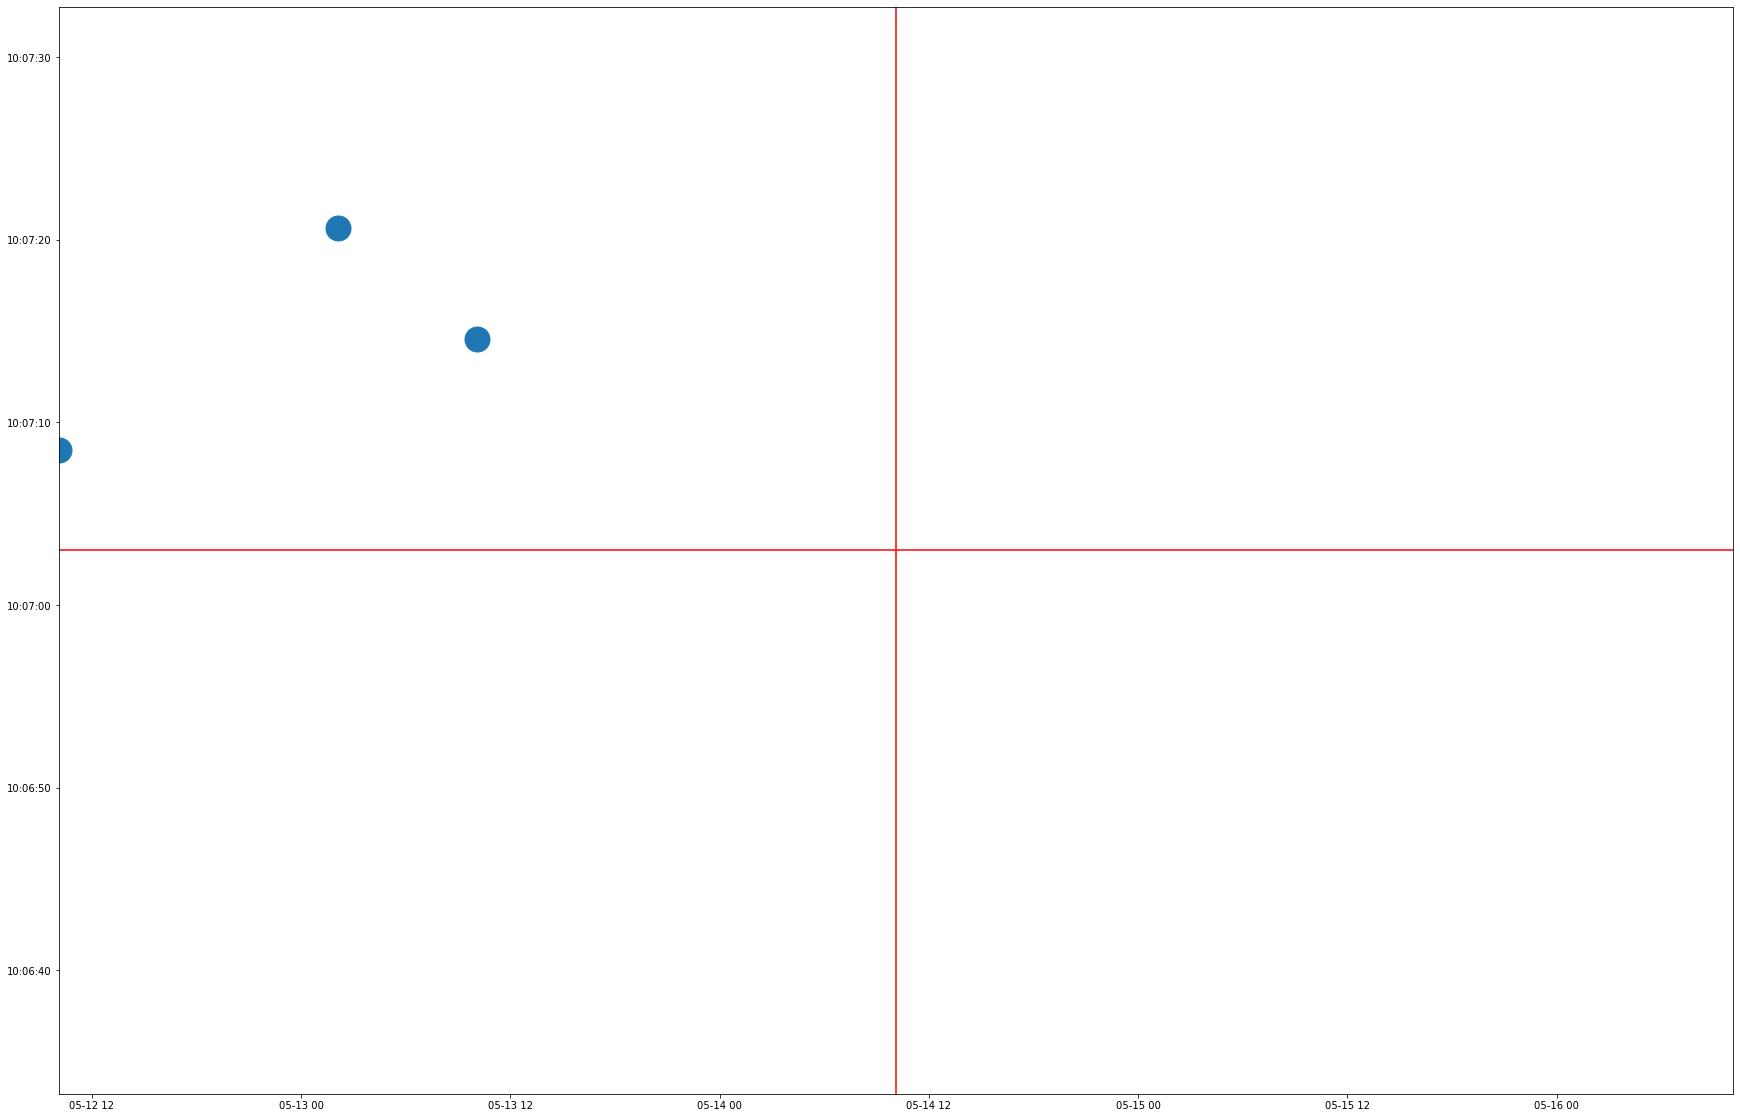

In [7]:
# Set the figure size
plt.figure(figsize=(30,20))

transaction_dates = [backdated_correction.transaction_date for backdated_correction in backdated_corrections]
entry_dates = [backdated_correction.entry_date_time for backdated_correction in backdated_corrections]

# Plot the asAt date (entry_date_time) against the effectiveAt date (transaction_date) to see the bi-temporal plot
plt.plot_date(
    x=transaction_dates,
    y=entry_dates,
    ms=25)

cut_off_date = datetime.strptime(cut_off, "%Y-%m-%dT%H:%M:%S%z")

# Add in a vertical and horizontal line for the origin 
plt.axvline(cut_off_date, color='r')
plt.axhline(cut_off_date, color='r')

# Set the min and max of each axis (modify these as appropriate to get the best looking chart)
plt.ylim(cut_off_date-(datetime.now(pytz.UTC)-cut_off_date), datetime.now(pytz.UTC))
plt.xlim(min(transaction_dates), cut_off_date+(cut_off_date - min(transaction_dates)))

# Show the plot
plt.show()